We start by importing all necessary modules.

In [1]:
%pylab inline
import pysam
import urllib.request
import traceback
import pysam
import timeit
from pyspark import SparkConf, SparkContext
import matplotlib.pyplot as plt
import numpy as np

Populating the interactive namespace from numpy and matplotlib


Next we initialize the Spark Context to allow us to utilize the Apache Spark functionality in our application.

In [2]:
conf = (SparkConf().setMaster("local[*]").setAppName("My app"))
sc = SparkContext(conf=conf)

This part is used in case we need to access the files without using Spark. Mostly this is used in order to be able to compare the performance of our implementation when not using Spark.

In [3]:
base_url = "http://130.238.29.253:8080/swift/v1/1000-genomes-dataset"
files = urllib.request.urlopen(base_url).read().split()
bams = [s.strip() for s in files if "bai" not in str(s) and "bas" not in str(s)]

The following function will take a url containing several .bam files as input. For each .bam file the function will extract all unmapped reads and divide them into 10-mers. run_pysam will also return the position of the kmer.

In [4]:
def run_pysam(url):
    try:
        with pysam.AlignmentFile(url, "rb") as bam:
            pos = []
            kmer = []
            index=0
            for b in bam.fetch(until_eof=True):
                if b.is_unmapped:
                    sub_kmer = []
                    start = b.query_alignment_start
                    stop = b.query_alignment_end
                    for i in range(start, stop - 9):
                        sub_kmer.append(b.query_sequence[i:i+10])
                    kmer = kmer + sub_kmer
                    pos.append(b.reference_start)
                    if index > 100000:
                        break
                index +=1
            return kmer,pos
    except Exception:
        traceback.print_exc()

rm_small_kmers is used to remove any non-frequent kmer or too-frequent kmer. A kmer is returned only if the count of that kmer is between 10-200 occurences.

In [8]:
def rm_small_kmers(k,v):
    if v > 10 and v < 200:
        return k,v
    else:
        return None,v

count_kmers returns a count of all kmers of the same type.

In [9]:
def count_kmers(kmers):
    number_of_kmers = kmers.flatMap(lambda x:x)                        \
                      .map(lambda x: (x,1))                            \
                      .reduceByKey(lambda x,y: x+y)                    \
                      .map(lambda x: rm_small_kmers(x[0], x[1]))       \
                      .reduceByKey(lambda x,y: x+y)
    return number_of_kmers

filter_positions allows for splitting the positions into chunks and counting how many positions fall into each chunk. This is used for the creation of the heatmap.

In [10]:
def filter_positions(positions,end,chunk):
    x = []
    intensity = []
    for r in range(1,end):
        pos = positions.filter(lambda x: x != None and x > chunk*(r-1) and x < chunk*r )
        x.append(chunk*r)
        intensity.append(pos.count())
    return x,intensity

Creates a heatmap of the postitions of kmers.

In [22]:
def create_heatmap(x,intensity,chunk):
    a = []
    a.append(intensity)
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(a, cmap=plt.cm.OrRd)
    ax.set_title('Heatmap of kmer positions')
    #ax.set_xticklabels(row_labels, minor=False)
    cur_axes = plt.gca()
    cur_axes.axes.get_yaxis().set_visible(False)

    ax.set_xlabel('Postition (x * ' + str(chunk) + ')')

    color = fig.colorbar(heatmap)

This is where the main functionality takes place. 

In [16]:
# Decides how many files we want to process. Set to len(bams) to use all files.
runs = 3

# Get the start-time for the main body of work. Used to calculate runtime.
t0 = timeit.default_timer()

# Here we run the run_pysam function on each file in the bam folder. The work is parallelized in
# order to improve the performance.
unmapped = sc.parallelize(bams[0:runs]).map(lambda x: base_url + "/" + str(x, 'utf-8').replace("'",""))\
                             .map(lambda x: run_pysam(x))
# We extract the positions and kmers from the RDD containing the unmapped reads.
positions = unmapped.map(lambda x : x[1]).flatMap(lambda x: x)
kmers = unmapped.map(lambda x : x[0])

pos = positions.collect()
# Get the count of each kmer.
number_of_kmers = count_kmers(kmers)
kmers_occurences = number_of_kmers.collect()

# Get the largest position.
maxpos = positions.max()
positions.cache()

# Divide the postitions into chunks and count how many falls into each chunk.
# This is used for the heatmap.
chunk = 25000
end = math.ceil(maxpos/chunk)
x,intensity = filter_positions(positions,end,chunk)

# Get the total runtime.
t1 = timeit.default_timer()

print("Total runtime Spark: ",t1-t0)

Total runtime Spark:  35.84356709202984


This section was used in order to compare the average performance of the application when running Spark vs not running Spark.

In [ ]:
# runs is how many files we want to process. 
# repeat is how many times we want to repeat each process allowing for average calculation.
runs = 4
repeat = 1

i = 0
total = 0

# This part runs the application without Spark.
while(i < repeat):
    t0 = timeit.default_timer()
    for b in bams[0:runs]:
        url = (base_url + "/" + str(b, 'utf-8')).replace("'","")
        kmer,pos = run_pysam(url)
    t1 = timeit.default_timer()
    total += t1-t0
    i+=1
print("Average runtime normal: ",float(total)/repeat)

# This part runs the application with Spark.
i = 0
total = 0
while(i < repeat):
    # Get the start-time for the main body of work. Used to calculate runtime.
    t0 = timeit.default_timer()

    # Here we run the run_pysam function on each file in the bam folder. The work is parallelized in
    # order to improve the performance.
    unmapped = sc.parallelize(bams[0:runs]).map(lambda x: base_url + "/" + str(x, 'utf-8').replace("'",""))\
                                 .map(lambda x: run_pysam(x))
    # We extract the positions and kmers from the RDD containing the unmapped reads.
    positions = unmapped.map(lambda x : x[1]).flatMap(lambda x: x)
    kmers = unmapped.map(lambda x : x[0])

    get = unmapped.collect()

    t1 = timeit.default_timer()
    total += t1-t0
    i+=1

print("Average runtime Spark: ",float(total)/repeat)

Average measurements for Spark vs No-Spark runs.

| Files | With Spark              | Without Spark      |
|:-----:| -----------------------:| ------------------:|
| 1     | 7.39162574732715        | 8.051276689996788  |
| 2     | 13.12760775531448       | 16.416337861679494 |
| 3     | 15.257276134992328      | 21.786817027333502 |
| 4     | 18.739379164995626      | 27.389469240336137 |
| 5     | 24.601100018665118      | 46.99257566700302  |
| 6     | 28.210006284663297      | 56.196963629995786 |

Create the heatmap for the positions.

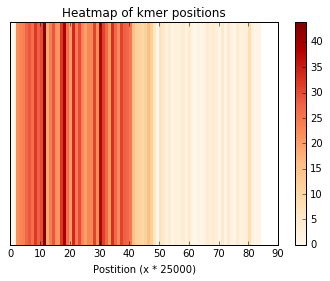

In [23]:
create_heatmap(x,intensity,chunk)